# **Recycling Waste Image Classification using Google Vertex AI AutoML API**

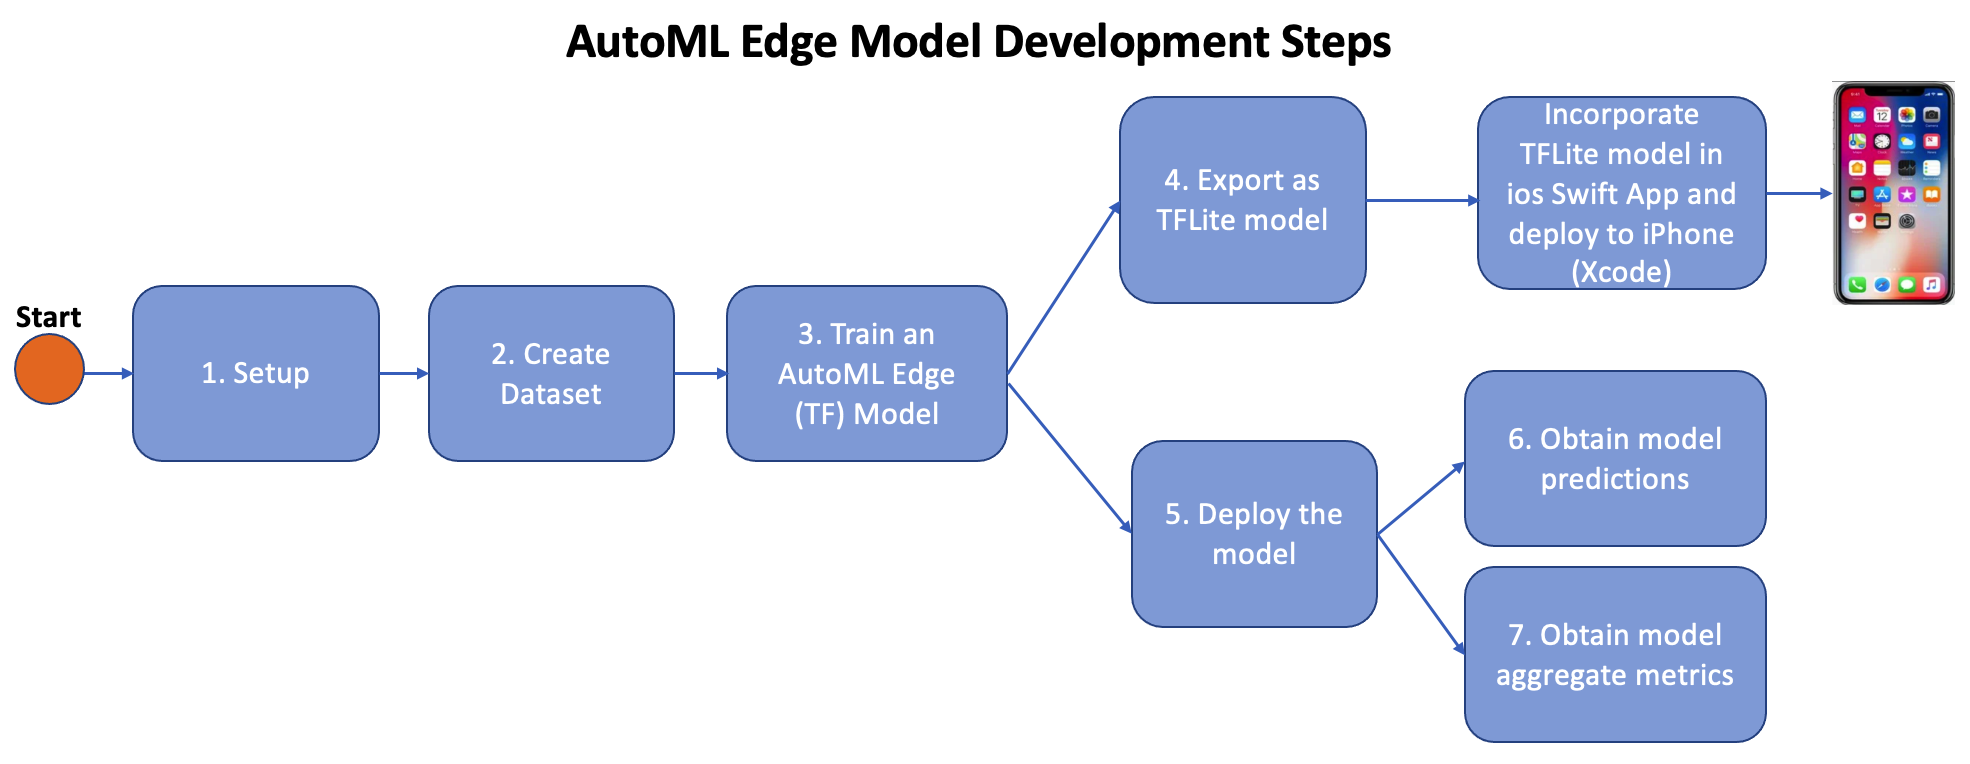

# **1. Setup**

## **1.1 Install Libraries**

In [1]:
! pip3 install -U git+https://github.com/googleapis/python-aiplatform.git@mb-release
! pip3 install -U google-cloud-storage
! pip3 install -U pillow
! pip3 install -U numpy

  Cloning https://github.com/googleapis/python-aiplatform.git (to revision mb-release) to /tmp/pip-req-build-h5xmp9nf
  Running command git clone -q https://github.com/googleapis/python-aiplatform.git /tmp/pip-req-build-h5xmp9nf
  Running command git checkout -q 4ed7a50fef58d694ddb29d4240965d44e383da2b
  Created wheel for google-cloud-aiplatform: filename=google_cloud_aiplatform-0.6.0a1-py2.py3-none-any.whl size=2264347 sha256=a0766bf8129c9a31a35feb50f4f3abc742f3ce1c37bca577aa8e08da3c360f22
  Stored in directory: /tmp/pip-ephem-wheel-cache-9xtlx6d3/wheels/9b/59/65/165494382f8202c284497ca153805f0f7c8c728f92df6b92d3
Successfully built google-cloud-aiplatform
  Found existing installation: google-cloud-aiplatform 0.6.0a1
    Uninstalling google-cloud-aiplatform-0.6.0a1:
      Successfully uninstalled google-cloud-aiplatform-0.6.0a1


Requirement already up-to-date: google-cloud-storage in /usr/local/lib/python3.7/dist-packages (1.38.0)
Requirement already up-to-date: pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)
Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)


### **1.1.1 Restart the kernel**

In [2]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

##**1.2 Import Libraries**

In [2]:
from typing import List, Union
from typing import Dict, Optional, Sequence, Tuple
from google.cloud import aiplatform
from google.cloud.aiplatform import explain

from keras.preprocessing.image import load_img
from matplotlib import pyplot

##**1.3 Set up Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**1.4 Set up the PROJECT ID**

In [4]:
PROJECT_ID = ""
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "brave-scanner-309900"  # @param {type:"string"}

##**1.5 Set up GOOGLE_APPLICATION_CREDENTIALS variable**

In [5]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on Google Cloud Notebooks, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/brave-scanner-309900-9e98bdaefd45.json'

# **2. Create a dataset for Recycling Images**

In [ ]:
def create_and_import_dataset_image_sample(
    project: str,
    location: str,
    display_name: str,
    src_uris: Union[str, List[str]],
    sync: bool = True,
):
    aiplatform.init(project=project, location=location)

    ds = aiplatform.ImageDataset.create(
        display_name=display_name,
        gcs_source=src_uris,
        import_schema_uri=aiplatform.schema.dataset.ioformat.image.single_label_classification,
        sync=sync,
    )

    ds.wait()

    print(ds.display_name)
    print(ds.resource_name)
    return ds

In [ ]:
location='us-central1'
display_nm='recyclingwaste_imagerecognition_finalproject_data'
src_uris='gs://recycling-images/datasets/recycling_images_dataset_finalproject.csv'
create_and_import_dataset_image_sample(PROJECT_ID,location,display_nm,src_uris)

recyclingwaste_imagerecognition_finalproject_data
projects/1093783107235/locations/us-central1/datasets/5252120755281330176


# **3. Train an AutoML Edge model - RecyclingWasteImageRecognizer**

In [ ]:
def automl_image_classification_training_job(
    project: str, location: str, dataset_id: str, display_name: str,
):
    aiplatform.init(project=project, location=location)

    dataset = aiplatform.ImageDataset(dataset_id)

    job = aiplatform.AutoMLImageTrainingJob(
        display_name=display_name,
        prediction_type="classification",
        multi_label=False,
        model_type="MOBILE_TF_HIGH_ACCURACY_1",
        #model_type="MOBILE_TF_VERSATILE_1",
        base_model=None,
    )

    model = job.run(
        dataset=dataset,
        model_display_name=display_name,
        training_fraction_split=0.8,
        validation_fraction_split=0.1,
        test_fraction_split=0.1,
        budget_milli_node_hours=8000,
        disable_early_stopping=False,
    )

    print(model.display_name)
    print(model.name)
    print(model.resource_name)
    print(model.description)
    print(model.uri)

    return model

In [ ]:
location='us-central1'
ds_id='5252120755281330176'
display_nm='FinalProjectRecyclingWasteImageModel'
automl_image_classification_training_job(PROJECT_ID,location,ds_id,display_nm)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/8325752734171004928?project=1093783107235
INFO:google.cloud.aiplatform.training_jobs:Training projects/1093783107235/locations/us-central1/trainingPipelines/8325752734171004928 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:Training projects/1093783107235/locations/us-central1/trainingPipelines/8325752734171004928 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:Training projects/1093783107235/locations/us-central1/trainingPipelines/8325752734171004928 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:Training projects/1093783107235/locations/us-central1/trainingPipelines/8325752734171004928 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:Training projects/1093783107235/l

# **4. Export the model as a tflite model (to use in ios app) to Google Storage Bucket**

In [ ]:
def export_model(
    project: str,
    model_id: str,
    gcs_destination_output_uri_prefix: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
    timeout: int = 300,
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    output_config = {
        "artifact_destination": {
            "output_uri_prefix": gcs_destination_output_uri_prefix
        },
        # For information about export formats: https://cloud.google.com/ai-platform-unified/docs/export/export-edge-model#aiplatform_export_model_sample-drest
        "export_format_id": "tflite",
    }
    name = client.model_path(project=project, location=location, model=model_id)
    
    response = client.export_model(name=name, output_config=output_config)
    print("Long running operation:", response.operation.name)
    print("output_info:", response.metadata.output_info)
    export_model_response = response.result(timeout=timeout)
    print("export_model_response:", export_model_response)


In [ ]:
location='us-central1'
model_id='3762766284761071616'
gcs_destination_output_uri_prefix="gs://recycling-images/tflite-model/"
export_model(PROJECT_ID,model_id,gcs_destination_output_uri_prefix,location)

Long running operation: projects/1093783107235/locations/us-central1/models/3762766284761071616/operations/6445003185365975040
output_info: artifact_output_uri: "gs://recycling-images/tflite-model/model-3762766284761071616/tflite/2021-06-04T03:20:07.532018Z"

export_model_response: 


# **5. Deploy the model for the evaluation**

In [6]:
def deploy_model_with_automatic_resources(
    project,
    location,
    model_name: str,
    endpoint: Optional[aiplatform.Endpoint] = None,
    deployed_model_display_name: Optional[str] = None,
    traffic_percentage: Optional[int] = 0,
    traffic_split: Optional[Dict[str, int]] = None,
    min_replica_count: int = 1,
    max_replica_count: int = 1,
    metadata: Optional[Sequence[Tuple[str, str]]] = (),
    sync: bool = True,
):

    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_name=model_name)

    model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        traffic_percentage=traffic_percentage,
        traffic_split=traffic_split,
        min_replica_count=min_replica_count,
        max_replica_count=max_replica_count,
        metadata=metadata,
        sync=sync,
    )

    model.wait()

    print(model.display_name)
    print(model.resource_name)
    return model

In [7]:
location="us-central1"
model_name='3762766284761071616'
deploy_model_with_automatic_resources(PROJECT_ID,location,model_name)

FinalProjectRecyclingWasteImageModel
projects/1093783107235/locations/us-central1/models/3762766284761071616


# **6. Obtain Model Predictions**

In [8]:
import base64

from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict


def predict_image_classification(
    project: str,
    endpoint_id: str,
    filename: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    with open(filename, "rb") as f:
        file_content = f.read()

    # The format of each instance should conform to the deployed model's prediction input schema.
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance = predict.instance.ImageClassificationPredictionInstance(
        content=encoded_content,
    ).to_value()
    instances = [instance]
    # See gs://google-cloud-aiplatform/schema/predict/params/image_classification_1.0.0.yaml for the format of the parameters.
    parameters = predict.params.ImageClassificationPredictionParams(
        confidence_threshold=0.5, max_predictions=5,
    ).to_value()
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # See gs://google-cloud-aiplatform/schema/predict/prediction/classification.yaml for the format of the predictions.
    predictions = response.predictions
    for prediction in predictions:
        print(" prediction:", dict(prediction))


In [9]:
endpoint_id="5767475049359474688"

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['AluminiumCan_RecycleEmptyCan'], 'ids': ['6130125870037204992'], 'confidences': [0.933051]}


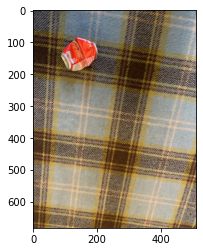

In [10]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/AluCantest.jpg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['7283047374644051968'], 'confidences': [0.948125839], 'displayNames': ['Cardboard_CleanCutAndRecycle']}


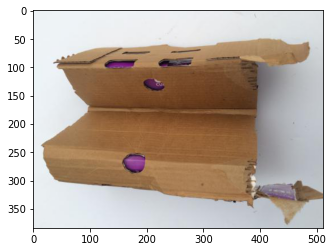

In [11]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/cardboard18test.jpg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['7138932186568196096'], 'confidences': [0.890972376], 'displayNames': ['FoodScraps_CompostOrganicWaste']}


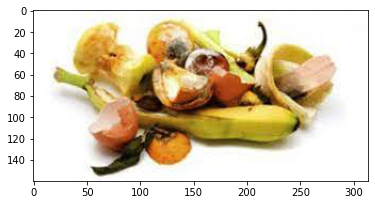

In [12]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/foodscraps.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['GlassBottle_RinseAndRecycle'], 'ids': ['5986010681961349120'], 'confidences': [0.696200311]}


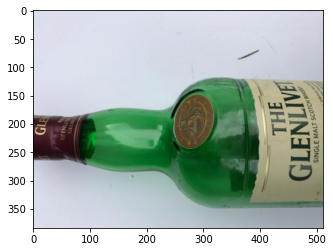

In [13]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/Glasstest.jpg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['4833089177354502144'], 'confidences': [0.886588812], 'displayNames': ['DetergentBTL_RecycleHDPEPlastic']}


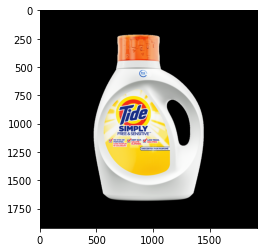

In [14]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/Detergent.png'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['MilkBTL_RecycleHDPEPlastic'], 'ids': ['2094900603913240576'], 'confidences': [0.89997524]}


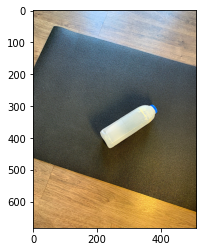

In [15]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/HDPEMfortest.JPG'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['941979099306393600'], 'confidences': [0.900257766], 'displayNames': ['Bottle_RecycleLDPEPlastic']}


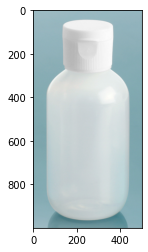

In [16]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/whitebottleLDPE.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['7859508126947475456'], 'confidences': [0.957403958], 'displayNames': ['FrozenBag_ReuseOrThrowInTrash']}


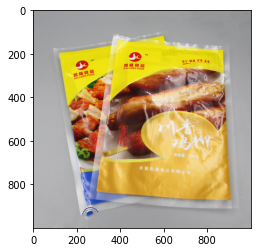

In [17]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/H11d1d57551014d2b97e152181cf5516a7.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['2671361356216664064'], 'confidences': [0.871467888], 'displayNames': ['GroceryBag_ReuseOrDropOffAtStore']}


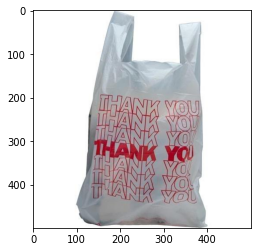

In [18]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/10-x-5-x-18-thank-you-shopping-bags-065-mil-769222_1000x1000.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['4400743613126934528'], 'confidences': [0.58723408], 'displayNames': ['Paper_SeparateByGradeAndRecycle']}


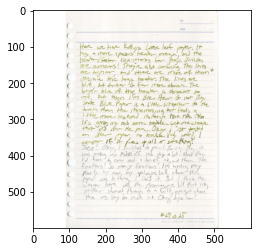

In [19]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/paper.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['ClamshellCTR_RecyclePETPlastic'], 'ids': ['1518439851609817088'], 'confidences': [0.940786541]}


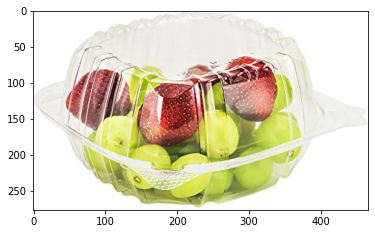

In [20]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/71MveSZ29EL._AC_SX466_.jpg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['9012429631554322432'], 'confidences': [0.913540125], 'displayNames': ['ClearCup_RecyclePETPlastic']}


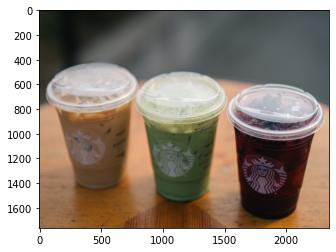

In [21]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/5f5b49cd7ed0ee001e25eb81.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['WaterBottle_RecyclePETPlastic'], 'ids': ['3824282860823511040'], 'confidences': [0.932905197]}


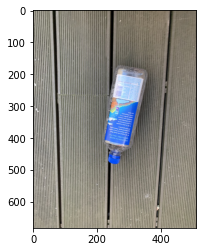

In [22]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/PETtestbottle.jpg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['RxCTR_RecyclePolypropylene'], 'ids': ['3680167672747655168'], 'confidences': [0.946191907]}


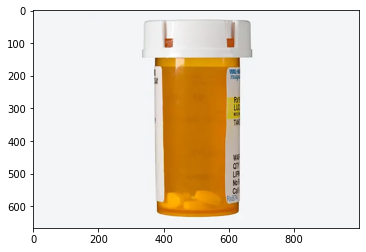

In [23]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/PrescriptionLabelDesign_Walmart_730.png'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['1374324663533961216'], 'confidences': [0.97414434], 'displayNames': ['YogurtCTR_RecyclePolypropylene']}


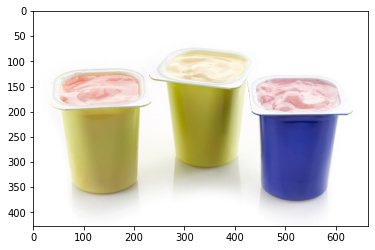

In [24]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/yogurt.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['221403158927114240'], 'confidences': [0.789014578], 'displayNames': ['PartyCup_RecyclePolystyrene']}


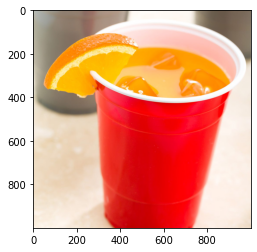

In [25]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/partycup2.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'displayNames': ['PlasticStraws_RecyclePolystyrene'], 'ids': ['8435968879250898944'], 'confidences': [0.873346031]}


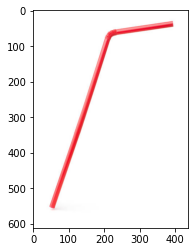

In [26]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/istockphoto-1053170490-612x612.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['3247822108520087552'], 'confidences': [0.871223629], 'displayNames': ['PlasticUtensils_RecyclePolystyrene']}


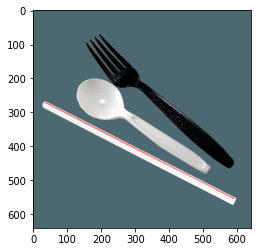

In [27]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/Utensils_201704061607286245.png'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['2527246168140808192'], 'confidences': [0.901047766], 'displayNames': ['Batteries_RecycleHazardousWaste']}


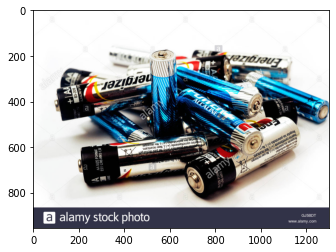

In [28]:
filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/recycling-of-used-batteries-of-different-brands-on-white-background-GJ5BDT.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['5553665117733781504'], 'confidences': [0.9251436], 'displayNames': ['StyrofoamCTR_RecyclePerInstr']}


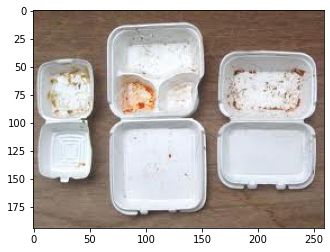

In [29]:

filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/styrofoamdirty.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

response
 deployed_model_id: 8793964367696625664
 prediction: {'ids': ['6706586622340628480'], 'confidences': [0.968072414], 'displayNames': ['StyrofoamCup_RecyclePerInstr']}


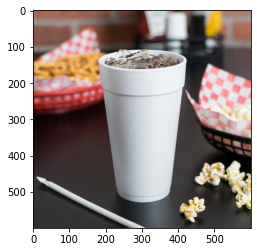

In [30]:

filename='gdrive/My Drive/Colab Notebooks/MSDS-462/FinalProject/testimages/950263.jpeg'
img = load_img(filename)
pyplot.imshow(img)
predict_image_classification(PROJECT_ID,endpoint_id,filename)

# **7. Obtain Aggregate Model Evaluation Metrics (Precision, Accuracy, Confusion matrix)**

In [31]:
def get_model_evaluation_image_classification(
    project: str,
    model_id: str,
    evaluation_id: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
    name = client.model_path(
        project=project, location=location, model=model_id
    )
    #response = client.list_model_evaluations(parent=name)
    #print("response:", response)
    for page in client.list_model_evaluations(parent=name).pages:
      print(page)

In [32]:
model_id='3762766284761071616'
evaluation_id='123'
get_model_evaluation_image_classification(PROJECT_ID,model_id,evaluation_id)

model_evaluations {
  name: "projects/1093783107235/locations/us-central1/models/3762766284761071616/evaluations/7063659620530651136"
  metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml"
  metrics {
    struct_value {
      fields {
        key: "auPrc"
        value {
          number_value: 0.9820225
        }
      }
      fields {
        key: "confidenceMetrics"
        value {
          list_value {
            values {
              struct_value {
                fields {
                  key: "precision"
                  value {
                    number_value: 0.04761905
                  }
                }
                fields {
                  key: "recall"
                  value {
                    number_value: 1.0
                  }
                }
              }
            }
            values {
              struct_value {
                fields {
                  key: "confidenceThreshold"
      